## TP Apprentissage par Renforcement avec MiniGrid

**Auteur:** SOW OUMOU - Ameto-Cornelia-ADANTO 


##  Installation et Imports

In [ ]:
# Installation des dépendances (décommentez si nécessaire)
# !pip install gymnasium minigrid numpy matplotlib torch tqdm

In [56]:
import gymnasium as gym
import minigrid
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from collections import defaultdict, deque
from tqdm import tqdm
import pickle
from collections import deque, namedtuple
import torch.optim as optim
import random

##  Partie 1: Exploration de MiniGrid

In [57]:
# Créer l'environnement
env = gym.make('MiniGrid-Empty-8x8-v0', render_mode='rgb_array')

print("Informations sur l'environnement:")
print(f"Espace d'observation: {env.observation_space}")
print(f"Espace d'actions: {env.action_space}")
print(f"Nombre d'actions: {env.action_space.n}")

Informations sur l'environnement:
Espace d'observation: Dict('direction': Discrete(4), 'image': Box(0, 255, (7, 7, 3), uint8), 'mission': MissionSpace(<function EmptyEnv._gen_mission at 0x00000124CF90C860>, None))
Espace d'actions: Discrete(7)
Nombre d'actions: 7


In [58]:
# Actions disponibles
actions = {
    0: "Tourner à gauche",
    1: "Tourner à droite",
    2: "Avancer",
    3: "Ramasser",
    4: "Déposer",
    5: "Basculer",
    6: "Terminer"
}

for action_id, description in actions.items():
    if action_id < env.action_space.n:
        print(f"Action {action_id}: {description}")

Action 0: Tourner à gauche
Action 1: Tourner à droite
Action 2: Avancer
Action 3: Ramasser
Action 4: Déposer
Action 5: Basculer
Action 6: Terminer


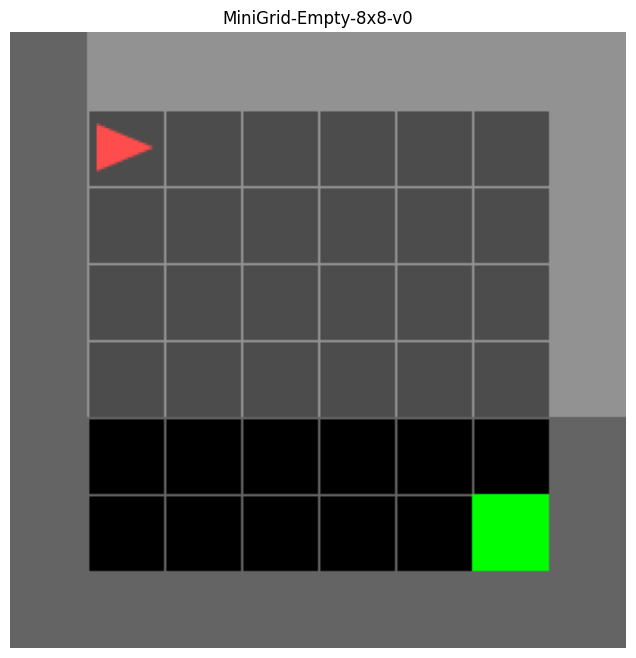


Structure de l'observation:
image: shape=(7, 7, 3)
direction: 0
mission: get to the green goal square


In [63]:
# Visualiser l'environnement
obs, info = env.reset()
img = env.render()

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title("MiniGrid-Empty-8x8-v0")
plt.axis('off')
plt.show()

print("\nStructure de l'observation:")
if isinstance(obs, dict):
    for key, value in obs.items():
        if isinstance(value, np.ndarray):
            print(f"{key}: shape={value.shape}")
        else:
            print(f"{key}: {value}")

##  Partie 2: Implémentation DQN

In [21]:
class DQNAgent:
    """
    Agent utilisant Deep Q-Network.
    
    Caractéristiques:
    - Réseau de neurones pour approximer Q
    - Replay buffer pour décorréler les expériences
    - Target network pour stabiliser l'apprentissage
    """
    
    def __init__(self,
                 input_size,
                 action_space_size,
                 hidden_sizes=[128, 64],
                 learning_rate=0.001,
                 gamma=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.01,
                 epsilon_decay=0.995,
                 buffer_capacity=10000,
                 batch_size=64,
                 target_update_freq=10):
        """
        Initialise l'agent DQN.
        
        Args:
            input_size: Taille de l'observation
            action_space_size: Nombre d'actions
            hidden_sizes: Architecture du réseau
            learning_rate: Taux d'apprentissage
            gamma: Facteur d'actualisation
            epsilon_start, epsilon_end, epsilon_decay: Paramètres epsilon-greedy
            buffer_capacity: Taille du replay buffer
            batch_size: Taille des mini-batches
            target_update_freq: Fréquence de mise à jour du target network
        """
        self.action_space_size = action_space_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        
        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Utilisation de: {self.device}")
        
        # Réseaux
        self.policy_net = DQN(input_size, action_space_size, hidden_sizes).to(self.device)
        self.target_net = DQN(input_size, action_space_size, hidden_sizes).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        # Optimiseur
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        
        # Replay buffer
        self.replay_buffer = ReplayBuffer(buffer_capacity)
        
        # Statistiques
        self.training_rewards = []
        self.training_steps = []
        self.losses = []
        self.update_count = 0
    
    def preprocess_state(self, state):
        """
        Prétraite l'observation pour l'entrée du réseau.
        
        Args:
            state: Observation brute
            
        Returns:
            Tensor PyTorch
        """
        if isinstance(state, dict) and 'image' in state:
            state = state['image'].flatten()
        elif isinstance(state, np.ndarray):
            state = state.flatten()
        else:
            state = np.array(state).flatten()
        
        return torch.FloatTensor(state).to(self.device)
    
    def select_action(self, state, training=True):
        """
        Sélectionne une action selon epsilon-greedy.
        
        Args:
            state: État actuel
            training: Mode entraînement ou évaluation
            
        Returns:
            Action sélectionnée
        """
        if training and random.random() < self.epsilon:
            return random.randint(0, self.action_space_size - 1)
        else:
            with torch.no_grad():
                state_tensor = self.preprocess_state(state).unsqueeze(0)
                q_values = self.policy_net(state_tensor)
                return q_values.argmax(1).item()
    
    def update(self):
        """
        Effectue une mise à jour du réseau avec un batch du replay buffer.
        """
        if len(self.replay_buffer) < self.batch_size:
            return None
        
        # Échantillonner un batch
        transitions = self.replay_buffer.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        
        # Convertir en tensors
        state_batch = torch.stack([self.preprocess_state(s) for s in batch.state])
        action_batch = torch.LongTensor(batch.action).unsqueeze(1).to(self.device)
        reward_batch = torch.FloatTensor(batch.reward).to(self.device)
        next_state_batch = torch.stack([self.preprocess_state(s) for s in batch.next_state])
        done_batch = torch.FloatTensor(batch.done).to(self.device)
        
        # Q-values actuelles
        current_q_values = self.policy_net(state_batch).gather(1, action_batch).squeeze()
        
        # Q-values futures (avec target network)
        with torch.no_grad():
            next_q_values = self.target_net(next_state_batch).max(1)[0]
            target_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values
        
        # Calculer la perte
        loss = self.loss_fn(current_q_values, target_q_values)
        
        # Optimisation
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping pour stabilité
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        self.update_count += 1
        
        # Mise à jour du target network
        if self.update_count % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        
        return loss.item()
    
    def decay_epsilon(self):
        """Décroît epsilon."""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

    def train(self, env, num_episodes=1000, max_steps=1000, verbose=True):
        """
        Entraîne l'agent DQN.
        
        Args:
            env: Environnement Gymnasium
            num_episodes: Nombre d'épisodes
            max_steps: Étapes max par épisode
            verbose: Affichage
            
        Returns:
            Historique d'entraînement
        """
        if verbose:
            print(f"\n{'='*60}")
            print(f"ENTRAÎNEMENT DQN")
            print(f"{'='*60}")
            print(f"Device: {self.device}")
            print(f"Épisodes: {num_episodes}")
            print(f"Batch size: {self.batch_size}")
            print(f"Buffer capacity: {self.replay_buffer.buffer.maxlen}")
            print(f"{'='*60}\n")
        
        episode_iterator = tqdm(range(num_episodes)) if verbose else range(num_episodes)
        
        for episode in episode_iterator:
            state, info = env.reset()
            episode_reward = 0
            episode_steps = 0
            episode_losses = []
            
            for step in range(max_steps):
                # Sélectionner et exécuter action
                action = self.select_action(state, training=True)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                
                # Stocker dans le buffer
                self.replay_buffer.push(state, action, reward, next_state, done)
                
                # Mise à jour du réseau
                loss = self.update()
                if loss is not None:
                    episode_losses.append(loss)
                
                episode_reward += reward
                episode_steps += 1
                state = next_state
                
                if done:
                    break
            
            # Décroissance epsilon
            self.decay_epsilon()
            
            # Statistiques
            self.training_rewards.append(episode_reward)
            self.training_steps.append(episode_steps)
            if episode_losses:
                self.losses.append(np.mean(episode_losses))
            
            # Affichage périodique
            if verbose and (episode + 1) % 100 == 0:
                avg_reward = np.mean(self.training_rewards[-100:])
                avg_steps = np.mean(self.training_steps[-100:])
                avg_loss = np.mean(self.losses[-100:]) if self.losses else 0
                tqdm.write(f"Épisode {episode+1}/{num_episodes} | "
                          f"Récompense: {avg_reward:.3f} | "
                          f"Étapes: {avg_steps:.1f} | "
                          f"Loss: {avg_loss:.4f} | "
                          f"Epsilon: {self.epsilon:.3f} | "
                          f"Buffer: {len(self.replay_buffer)}")
        
        return {
            'rewards': self.training_rewards,
            'steps': self.training_steps,
            'losses': self.losses
        }

In [24]:
# Créer l'environnement
env = gym.make('MiniGrid-Empty-8x8-v0')

# Obtenir la taille de l'observation
obs, _ = env.reset()
if isinstance(obs, dict) and 'image' in obs:
    input_size = obs['image'].flatten().shape[0]
else:
    input_size = np.array(obs).flatten().shape[0]

print(f"Taille observation: {input_size}")

# Créer l'agent DQN
agent_dqn = DQNAgent(
    input_size=input_size,
    action_space_size=env.action_space.n
)

# Entraîner
history_dqn = agent_dqn.train(env, num_episodes=500, max_steps=500)
env.close()

Taille observation: 147
Utilisation de: cpu

ENTRAÎNEMENT DQN
Device: cpu
Épisodes: 500
Batch size: 64
Buffer capacity: 10000



 20%|██        | 100/500 [04:05<16:15,  2.44s/it]

Épisode 100/500 | Récompense: 0.100 | Étapes: 234.7 | Loss: 1.2449 | Epsilon: 0.606 | Buffer: 10000


 40%|████      | 200/500 [07:00<09:03,  1.81s/it]

Épisode 200/500 | Récompense: 0.370 | Étapes: 170.3 | Loss: 0.0252 | Epsilon: 0.367 | Buffer: 10000


 60%|██████    | 300/500 [10:42<03:33,  1.07s/it]

Épisode 300/500 | Récompense: 0.194 | Étapes: 213.5 | Loss: 0.0054 | Epsilon: 0.222 | Buffer: 10000


 80%|████████  | 400/500 [12:53<02:08,  1.29s/it]

Épisode 400/500 | Récompense: 0.295 | Étapes: 187.6 | Loss: 0.0013 | Epsilon: 0.135 | Buffer: 10000


100%|██████████| 500/500 [14:36<00:00,  1.75s/it]

Épisode 500/500 | Récompense: 0.581 | Étapes: 114.0 | Loss: 0.0011 | Epsilon: 0.082 | Buffer: 10000


In [26]:
def evaluate(self, env, num_episodes=100, max_steps=1000):
        """
        Évalue l'agent.
        
        Args:
            env: Environnement
            num_episodes: Nombre d'épisodes
            max_steps: Étapes max
            
        Returns:
            Statistiques d'évaluation
        """
        rewards = []
        steps = []
        successes = 0
        
        self.policy_net.eval()
        
        for episode in range(num_episodes):
            state, info = env.reset()
            episode_reward = 0
            episode_steps = 0
            
            for step in range(max_steps):
                action = self.select_action(state, training=False)
                state, reward, terminated, truncated, info = env.step(action)
                
                episode_reward += reward
                episode_steps += 1
                
                if terminated or truncated:
                    if reward > 0:
                        successes += 1
                    break
            
            rewards.append(episode_reward)
            steps.append(episode_steps)
        
        self.policy_net.train()
        
        return {
            'mean_reward': np.mean(rewards),
            'std_reward': np.std(rewards),
            'mean_steps': np.mean(steps),
            'std_steps': np.std(steps),
            'success_rate': successes / num_episodes,
            'rewards': rewards,
            'steps': steps
        }

 Graphique sauvegardé dans : results/courbes_apprentissage_dqn.png


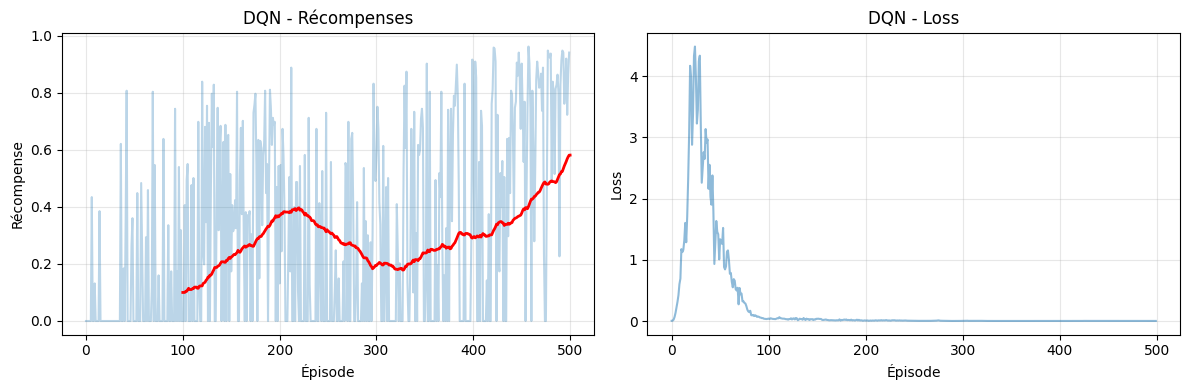

In [53]:
# Visualiser
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
window = 100
moving_avg = np.convolve(history_dqn['rewards'], np.ones(window)/window, mode='valid')
plt.plot(history_dqn['rewards'], alpha=0.3)
plt.plot(range(window, len(history_dqn['rewards'])+1), moving_avg, 'r-', linewidth=2)
plt.xlabel('Épisode')
plt.ylabel('Récompense')
plt.title('DQN - Récompenses')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
if history_dqn['losses']:
    plt.plot(history_dqn['losses'], alpha=0.5)
    plt.xlabel('Épisode')
    plt.ylabel('Loss')
    plt.title('DQN - Loss')
    plt.grid(True, alpha=0.3)

plt.tight_layout()

#  Sauvegarde dans le dossier results 
plt.savefig('results/courbes_apprentissage_dqn.png', dpi=300)
print(" Graphique sauvegardé dans : results/courbes_apprentissage_dqn.png")

plt.show()

##  Partie 3: Implémentation DQN+CNN

 Courbes sauvegardées sous : results\courbes_apprentissage_dqn_cnn.png


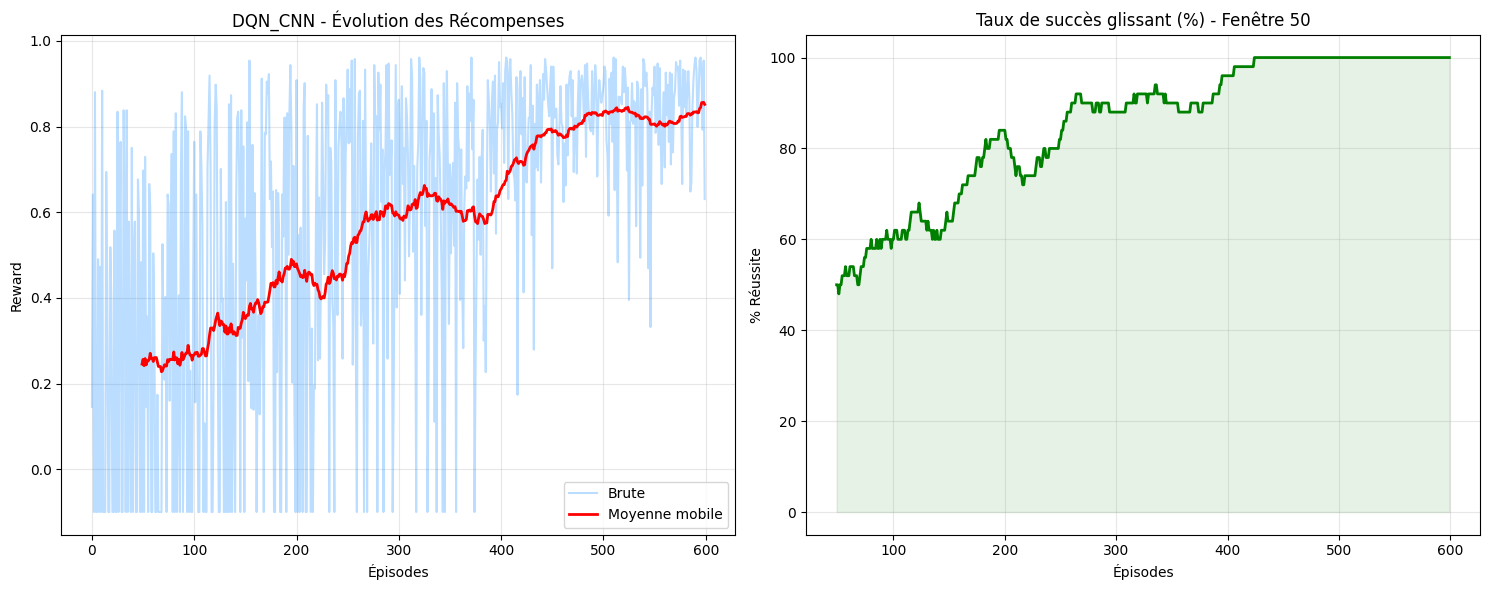

In [52]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

PATH = "models/dqn_minigrid/best_model.pth"
SAVE_DIR = "results" 
window = 50

def visualize_and_save():
    # Créer le dossier résultat s'il n'existe pas
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)
        print(f" Dossier '{SAVE_DIR}' créé.")

    try:
        # CHARGEMENT
        checkpoint = torch.load(PATH, map_location='cpu', weights_only=False)
        rewards = checkpoint.get('training_rewards', [])
        
        if not rewards:
            print(" Aucune donnée de récompense trouvée.")
            return

        plt.figure(figsize=(15, 6))

        # 1. Courbe des Récompenses
        plt.subplot(1, 2, 1)
        plt.plot(rewards, alpha=0.3, color='dodgerblue', label='Brute')
        if len(rewards) >= window:
            smooth = np.convolve(rewards, np.ones(window)/window, mode='valid')
            plt.plot(range(window-1, len(rewards)), smooth, color='red', linewidth=2, label='Moyenne mobile')
        plt.title("DQN_CNN - Évolution des Récompenses")
        plt.xlabel("Épisodes")
        plt.ylabel("Reward")
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 2. Taux de Succès Glissant
        plt.subplot(1, 2, 2)
        success = [1 if r > 0 else 0 for r in rewards]
        if len(success) >= window:
            roll = np.convolve(success, np.ones(window)/window, mode='valid') * 100
            plt.plot(range(window-1, len(success)), roll, color='green', linewidth=2)
            plt.fill_between(range(window-1, len(success)), roll, color='green', alpha=0.1)
        plt.title(f"Taux de succès glissant (%) - Fenêtre {window}")
        plt.xlabel("Épisodes")
        plt.ylabel("% Réussite")
        plt.ylim(-5, 105)
        plt.grid(True, alpha=0.3)

        plt.tight_layout()

        # SAUVEGARDE
        save_path = os.path.join(SAVE_DIR, "courbes_apprentissage_dqn_cnn.png")
        plt.savefig(save_path, dpi=300) 
        print(f" Courbes sauvegardées sous : {save_path}")

        plt.show()

    except FileNotFoundError:
        print(f" Fichier {PATH} non trouvé.")

if __name__ == "__main__":
    visualize_and_save()